From from this article: [Time Series — ARIMA vs. SARIMA vs. LSTM: Hands-On Tutorial](https://towardsdatascience.com/time-series-arima-vs-sarima-vs-lstm-hands-on-tutorial-bd5630298da3)

First we want to start off with downloading the data. It can be had from [here](https://archive.ics.uci.edu/dataset/360/air+quality). It's around 1 MB.

The data is a gas sensor array with hourly readings. The readings are averaged from 5
sensors for each hourly entry. Columns with (GT) are the ground truth values from a
co-located reference sensor, similarly averaged across multiple sensors, averaged
hourly.

In [1]:
# import libraries
import pandas as pd
import numpy as np

from ucimlrepo import fetch_ucirepo

In [2]:
# Fetch dataset
air_quality = fetch_ucirepo(id=360)

Get the data from the data set.

Same thing with many names:
- Features, X, input variables, independent variables
- Targets, y, output variables, dependent variables

In [3]:
# Data (as pandas dataframe)
air_quality_df = air_quality.data.features
air_quality_df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,3/10/2004,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,3/10/2004,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,3/10/2004,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,3/10/2004,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,3/10/2004,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


Explore the data a bit.

In [4]:
air_quality_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   int64  
 4   NMHC(GT)       9357 non-null   int64  
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   int64  
 7   NOx(GT)        9357 non-null   int64  
 8   PT08.S3(NOx)   9357 non-null   int64  
 9   NO2(GT)        9357 non-null   int64  
 10  PT08.S4(NO2)   9357 non-null   int64  
 11  PT08.S5(O3)    9357 non-null   int64  
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
dtypes: float64(5), int64(8), object(2)
memory usage: 1.1+ MB


See statistics of the data.

In [5]:
air_quality_df.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-34.207524,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,9.778305,39.485380,-6.837604
std,77.657170,329.832710,139.789093,41.380206,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,43.203623,51.216145,38.976670
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,0.600000,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,10.900000,34.100000,0.692300
50%,1.500000,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800
75%,2.600000,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


From the documentation for this data: Missing values are tagged with -200 value. Let's
see how many are -200 in each column. This can give us an idea of how to handle them.

In [6]:
# Do an element wise comparison on all values, then sum up for each column.
missing_values_count = (air_quality_df == -200).sum()
missing_values_count

Date                0
Time                0
CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64

This is great! We see how many values are effectively null. Let's get a percentage too
so we can see for each column what the percentage of null (-200) there is.

In [7]:
# Calculate the percentage of missing values for each column. Rount to whole int
missing_values_percentage = ((missing_values_count / len(air_quality_df)) * 100).round().astype(int)
missing_values_percentage

Date              0
Time              0
CO(GT)           18
PT08.S1(CO)       4
NMHC(GT)         90
C6H6(GT)          4
PT08.S2(NMHC)     4
NOx(GT)          18
PT08.S3(NOx)      4
NO2(GT)          18
PT08.S4(NO2)      4
PT08.S5(O3)       4
T                 4
RH                4
AH                4
dtype: int64

<!--TODO on second pass: For the readings, let's use the average value of the column to fill in the missing values. -->
## Feature Engineering
We'll handle missing values by dropping them.

In [8]:
# Show column count and row count for before and after dropping missing values
air_quality_df.shape

(9357, 15)

In [9]:
# Replace missing values and drop unnecessary columns.

# Replace -200 with NaN
air_quality_df.replace(-200, np.nan, inplace=True)
# Drop columns where all values are NaN
# - axis=1 means columns, how='all' means only drop if all values in the column are NaN
air_quality_df.dropna(axis=1, how='all', inplace=True)
air_quality_df.shape


(9357, 15)

In [10]:
# Drop any rows with missing values.
air_quality_df.dropna(inplace=True)
air_quality_df.shape

(827, 15)

Not great, we lost most the data set. I don't like how the tutorial handled this.
I think we can do better. TODO: come back to this

Now let's combine the Date and Time columns into a single datetime column.

In [11]:
# Combine Date and Time columns into a single datetime column
air_quality_df['DateTime'] = pd.to_datetime(air_quality_df['Date'] + ' ' + air_quality_df['Time'])
air_quality_df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,DateTime
0,3/10/2004,18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,2004-03-10 18:00:00
1,3/10/2004,19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,2004-03-10 19:00:00
2,3/10/2004,20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,2004-03-10 20:00:00
3,3/10/2004,21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,2004-03-10 21:00:00
4,3/10/2004,22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,2004-03-10 22:00:00


We can set the new datetime column as the index since we're working with time series
data, then sort the data by the index.
Note 💡: Inplace is more memory efficient than having it return one and then re-assigning
it back to the variable.

In [12]:
air_quality_df.set_index('DateTime', inplace=True)
air_quality_df.sort_index(inplace=True)

The tutorial picks Nox(GT) as the target variable without a reason why, so we'll use
that too, but don't ask me why. 😅

In [13]:
# Grab the target column.
# Note 💡: This also grabs the index column, so you'll have a df with two columns.
target = air_quality_df['NOx(GT)']
target.head()

DateTime
2004-03-10 18:00:00    166.0
2004-03-10 19:00:00    103.0
2004-03-10 20:00:00    131.0
2004-03-10 21:00:00    172.0
2004-03-10 22:00:00    131.0
Name: NOx(GT), dtype: float64

## Visualize
Let's visualize the data to see what we're working with. Visualizing is great. Always
visualize. ✨📊

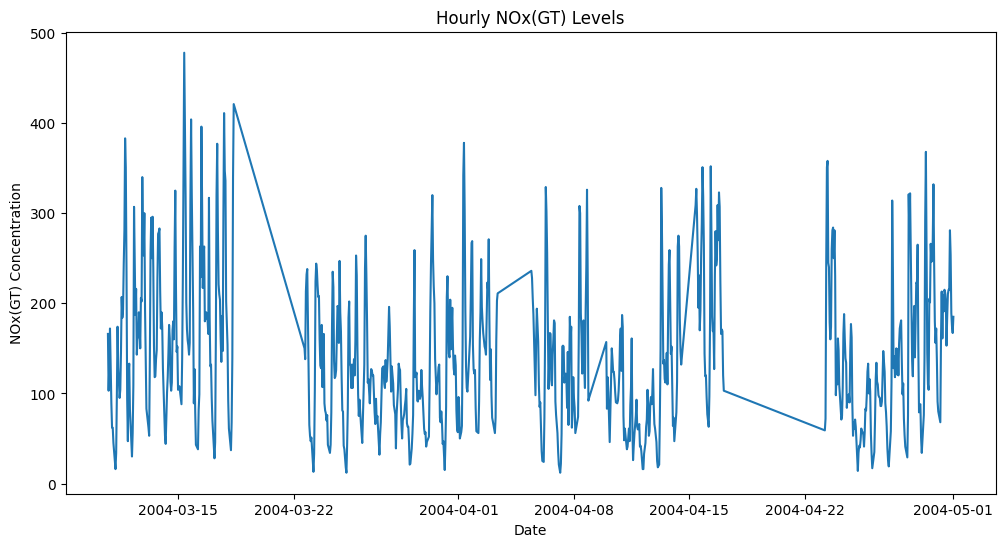

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(target)
plt.title('Hourly NOx(GT) Levels')
plt.xlabel('Date')
plt.ylabel('NOx(GT) Concentration')
plt.show()



## Train Test Split
80/20 split. We'll use the last 20% of the data as the test set.
Note 💡: When the index for the data is an integer we can do normal slicing. But when
the index is an object like a date, which is what we have here, we need to use iloc
instead.

In [15]:
# Get the index for where 80% falls.
train_size = int(len(target) * 0.8)


train, test = target.iloc[:train_size], target.iloc[train_size:]
train.shape, test.shape

((661,), (166,))

# Modeling
Now to the fun part! We can start digging into making models.

Some definitions:
- Autocorrelation: Measures the correlation of a time series with a lagged (previous) version of itself. It indicates how past values of the series are related to current values. If a time series of temperature readings shows high, the current is influenced by the past, like today's temperature is influenced by yesterday's temperature.

- Stationary: Mean, variance, and autocorrelation do not change over time. A good example of a stationary data set would be the humidity in a greenhouse. The humidity will fluctuate around the set value. The mean, variance, and autocorrelation will not change over time.
- Non-Stationary: Mean, variance, and autocorrelation do change over time. When they change, there's some specific terms for the ways they change.
  - Trend: The changes in in mean over time. For example the cost of living goes up overtime because of inflation.
  - Seasonality: Changes on a regular cadence. Like sales that are affected by the time of year like around holidays.
  - Variation: How the spread of the data changes over time. Measure of fluctuation around the average.

## ARIMA

Autoregressive Integrated Moving Average. ARIMA is a univariate linear model. It does not support seasonality in data. ARIMA parameters are: ARIMA(p, d, q). These three parameters account for seasonality, p, trend, d, and noise, q, in data.
  - p: Indicates the number of past values (lags) of the time series that the model will use to predict the current value. p=1 means that the model will use the last value to predict the current value, whicle p=2 means that the model will use the last two values to predict the current value, and so on. This is the order of the autoregressive, AR, part of the model.
  - d: Indicates the number of differences that the model will use to make the time series stationary. d=1 means that the model will use the first difference of the time series, d=2 means that the model will use the second difference of the time series, and so on. This is the order of integration, I, part of the model.
  - q: The number of previous forecast errors to use to adjust the current forecast prediction. The moving average, MA, part of the model. q=1 means that the model will use the last forecast error to adjust the current forecast, q=2 means that the model will use the last two forecast errors to adjust the current forecast, and so on.

### Convert to Darts series
We'll use Darts as our framework for all the models.

In [16]:
from darts import TimeSeries
# This implementation is a thin wrapper around pmdarima AutoARIMA model
from darts.models import AutoARIMA

/Users/demon_slayer/Documents/GitHub/Data-Science-Learning/ARIMA vs SARIMA vs LSTM/poetry/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/demon_slayer/Documents/GitHub/Data-Science-Learning/ARIMA vs SARIMA vs LSTM/poetry/.venv/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Of note is that Darts will not be able to infer the frequency of this data. Sometimes it
can, but with this data it can't. We can check this by looking to see if
`train.index.freq` is None. If it is, the frequency is not set. This data is hourly, so
we can set the frequency to 'h'.

In [ ]:
print(train.index)
# If train.index.freq is None, then we need to set it manually
print(train.index.freq)

DatetimeIndex(['2004-03-10 18:00:00', '2004-03-10 19:00:00',
               '2004-03-10 20:00:00', '2004-03-10 21:00:00',
               '2004-03-10 22:00:00', '2004-03-10 23:00:00',
               '2004-03-11 00:00:00', '2004-03-11 01:00:00',
               '2004-03-11 02:00:00', '2004-03-11 05:00:00',
               ...
               '2004-04-17 01:00:00', '2004-04-17 02:00:00',
               '2004-04-23 05:00:00', '2004-04-23 06:00:00',
               '2004-04-23 07:00:00', '2004-04-23 08:00:00',
               '2004-04-23 09:00:00', '2004-04-23 10:00:00',
               '2004-04-23 11:00:00', '2004-04-23 12:00:00'],
              dtype='datetime64[ns]', name='DateTime', length=661, freq=None)
None


Our data has some gaps in the readings, not every hour has a reading. When we set the
frequency to 'h', it will fill in the missing values with NaN by default, but we can't
use NaN's in the model. We'll use forward fill for now just to input something. TODO:
do something smarter here.

In [ ]:
# Set the frequency to hourly
train = train.asfreq('h', method='ffill')
# Double check NaN counts
train.isna().sum()

0

In [19]:
type(train)

pandas.core.series.Series

In [ ]:
# Convert the pandas series to a Darts TimeSeries
darts_train = TimeSeries.from_series(train)

### d

We want to make non-stationary data into stationary data. There's some ways to do this, we'll use differencing here. Differencing is subtracting the previous value from the current value. This aims to remove trends from the data.

Some ways exist to tell if a dataset needs differencing. We'll use ADF (Augmented Dickey-Fuller) test. This test looks for Mean Reversion vs. Random Walk. In a stationary series, values may fluctuate, but revert to a stable mean. In a non-stationary series, it will act more like someone walking at random where the next step doesn't depend on the previous step.
With this, if the p-value is less than a threshold, say 5%, then the dataset is stationary. If it's greater than 5%, then the dataset is non-stationary and we should difference it.

In [ ]:
from darts.utils.statistics import stationarity_test_adf

# ADF Test, adf is the default stationarity test
stationarity_test_result = stationarity_test_adf(darts_train)

# Grab the p-value and make it have 1 decimal place
p_value = (stationarity_test_result[1]*100).round(1)

print(f'P-Value: {p_value}%' + (' (Stationary)' if p_value < 5 else ' (Non-Stationary)'))
# TODO, left off here

It's greater than 5% that we want to see, so we'll difference the data.

Each time we difference it, it is one order of differencing. So this is a first order
differencing. You can difference it more but doing it more than twice, ends up hurting
more than helping and ruins the data. So we'll do it once, maybe twice.

In [ ]:
# First-order differencing
train_diff = train.diff()

# Remove the first NaN value
train_diff.dropna(inplace=True)
train_diff


In [ ]:

# Check ADF p-value again
adf_result = adfuller(train_diff)
p_value = (adf_result[1]*100).round(1)

print(f'P-Value: {p_value}%' + (' (Stationary)' if p_value < 5 else ' (Non-Stationary)'))

Nice! The data is now stationary.

### p

### q

Now that we understand these parameters better, let's hand it off to an auto finder that
can find the best parameters for us.

### Auto ARIMA

In [ ]:
# Create the model
auto_arima_model = AutoARIMA(
    darts_train,
    start_p=1,
    max_p=24, # 24 hours in a day, so if there's a cycle it can see this
    #d=None, # let model determine 'd' - None is the default
    start_q=1,
    max_q=24, # 24 hours in a day, so if there's a cycle it can see this
    # m=1, # Frequency of series, 1 means a non-seasonal series. 4 would be quarterly,
    #   etc. Default is 1.
    # seasonal=False, # Non-seasonal data. Default True, but if m=1, this is set to
    #   False. It can be left commented out because m=1 is the default.
    test='adf', # Test to determine d. Default is kpss.
    # stepwise=True, # Method for determining the best parameters. When using stepwise
    #   it can fit faster and be less likely to over-fit. Default is True.
    trace=True # Print some debug info on fits. Default is False.
    # suppress_warnings=True # Set to True to suppress warnings from statsmodels.
    #   Default is True.
)


When we instantiate the ARIMA model with the data it calls fit, so we can check the
summary of the model right away.

In [ ]:
auto_arima_model.fit(darts_train)

In the results we're looking at the AIC, Akaike Information Criterion, values. Lower
values are better, so it selects which parameters produce the lowest AIC value. The
ARIMA method is ARIMA(p, d, q) and the results show (1, 0, 1). So it's suggesting we
don't need to difference the data, which is fine, we'll go with that. We can check the
summary too.

In [ ]:
auto_arima_model.model.summary()

📝 If the outer covariance matrix with product of gradients warning is showing, it's just
because the typical method using a Hessian matrix couldn't be used. The variance
estimates between the two should be mimimal so we are ok with that.

Let's implement the ARIMA model with the parameters it found! Like a box cake mix, just
add water! 🎂

First we'll have to do the same transformations to the test data that we did to the
train data.

In [ ]:
from darts.models import ARIMA


# If test.index.freq is None, then we need to set it manually
print(f'Test index frequency: {test.index.freq}')

# Set the frequency to hourly
test = test.asfreq('h', method='ffill')

# Double check NaN counts
print(f'Nan Count after setting frequency: {test.isna().sum()}')

# Convert the pandas series to a Darts TimeSeries
darts_test = TimeSeries.from_series(test)


💡: The arima model can have a contant term. In the AutoARIMA output, this is indicated
when it says `intercept`. If there's an intercept, we want to set trend to c for
constant, n for no intercept. This represents the average of the series that it
fluctuates around.

In [ ]:
test_series = TimeSeries.from_series(test)

# Fit the ARIMA model
p, d, q = auto_arima_model.model.model_.order

arima_intercept = 'c' if auto_arima_model.model.model_.with_intercept else 'n'
arima_model = ARIMA(p, d, q, trend=arima_intercept)
arima_model.fit(darts_test)

# Forecast
arima_forecast = arima_model.predict(n=len(test_series))


📊 Let's take a peek at the predictions vs actuals. We'll do more analysis later after
we have all the models.

In [ ]:
# Visualize
plt.figure(figsize=(12, 6))

# Actuals
plt.plot(test.index, test.values, label='Actual', color='black')

# ARIMA predictions
plt.plot(test.index, arima_forecast.values(), label='ARIMA', color='blue')

plt.title('Predicted vs Actual')
plt.xlabel('Date')
plt.ylabel('NOx Concentration')
plt.legend()
plt.show()